In [2]:
pip install xgboost


In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [5]:
# Load data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRC4x6mecC7EkofiP3uJWZ3Y1jD1B2QMZXjlFtdP9-TOan6Fms2TqyOyssHegjTeG7iM6f-qX89vfvK/pub?gid=0&single=true&output=csv"
df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'], format='%m-%Y')
df.set_index('Date', inplace=True)
df['Biomass']=df['Biomass'].dropna()

In [6]:
# Assuming df is your DataFrame with the 'Biomass' column
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back)]
        X.append(a)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

# Define look_back period and prepare the dataset
look_back = 5
X, y = create_dataset(df['Biomass'].values, look_back)


In [8]:
# Define a range of parameters for GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "colsample_bytree": [0.5, 0.7, 1],
    "subsample": [0.6, 0.8, 1]
}

# Create XGBoost regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

# Create GridSearchCV
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)


In [9]:
# Fit the grid search model
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}


In [10]:
# Train the final model with best parameters
final_xg_model = xgb.XGBRegressor(**best_params)
final_xg_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
# Make predictions on the training set
train_predictions = final_xg_model.predict(X)

In [14]:
# Calculate MSE
mse = mean_squared_error(y, train_predictions)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y, train_predictions)

# Calculate R-squared
r2 = r2_score(y, train_predictions)

# Calculate MAPE - ensure no division by zero
y_actual_nonzero = np.where(y == 0, np.finfo(float).eps, y)  # Replace 0 with a small number
mape = np.mean(np.abs((y - train_predictions) / y_actual_nonzero)) * 100

# Print the error metrics
print(f"Training Metrics:\nMSE: {mse}\nRMSE: {rmse}\nMAE: {mae}\nMAPE: {mape}\nR-squared: {r2}")


Training Metrics:
MSE: 215.55839763494814
RMSE: 14.681907152510812
MAE: 11.727482949281349
MAPE: 4.44475637775503
R-squared: 0.9136343247295994


In [11]:
# Forecast future values for the next 30 months
future_months = 30
future_predictions = []
last_window = df['Biomass'].values[-look_back:]

for _ in range(future_months):
    pred = final_xg_model.predict(np.array([last_window]))
    future_predictions.append(pred[0])
    last_window = np.append(last_window[1:], pred)

future_dates = pd.date_range(start=df.index[-1], periods=future_months + 1, freq='M')[1:]
future_series = pd.Series(future_predictions, index=future_dates)


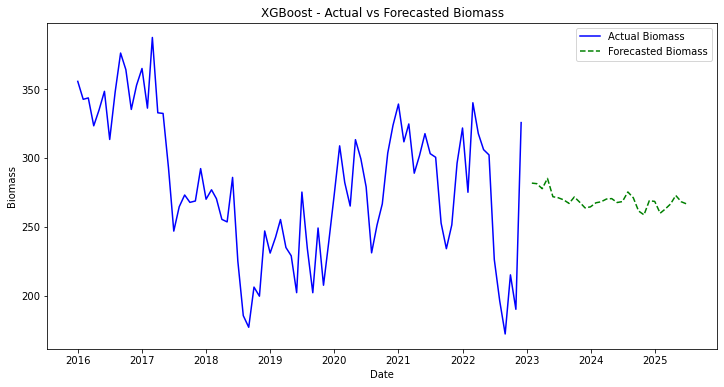

In [12]:
# Plotting the original and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Biomass'], label='Actual Biomass', color='blue')
plt.plot(future_series.index, future_series, label='Forecasted Biomass', color='green', linestyle='dashed')
plt.title('XGBoost - Actual vs Forecasted Biomass')
plt.xlabel('Date')
plt.ylabel('Biomass')
plt.legend()
plt.show()
